In [1]:
!python --version

Python 3.12.3


In [5]:
import torch
torch.__version__

'2.3.0+cu121'

# Install and import libraries

In [1]:
#!pip install flash_attn einops timm

# pip install transformers
# pip install timm
# pip install packaging
# pip install wheel
# pip install ninja
# pip install flash_attn
# pip install einops
#!pip install accelerate

In [2]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForCausalLM

/home/aarohi/florence2_env/florence2_env1/myvenv/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Import Florence-2 model

In [3]:
model_id = 'microsoft/Florence-2-large'
#model_id = 'microsoft/Florence-2-base'

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)




In [4]:
def florence2(task_prompt, images, text_input=None):
    """
    Calling the Microsoft Florence2 model
    """
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids,
                                            skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height))

    return parsed_answer



# Image captioning


A man standing next to an elephant in a forest.



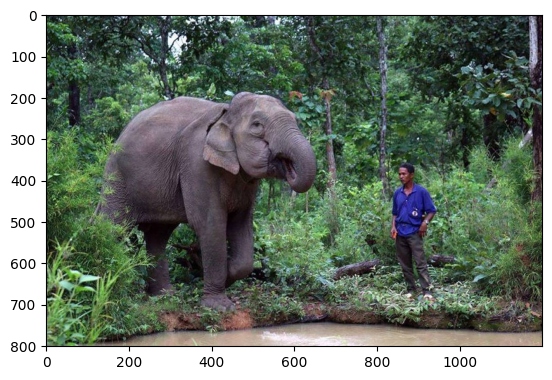

In [5]:
task_prompt = '<CAPTION>'
image = Image.open('testimages/animal1.jpg')
caption1 = list(florence2(task_prompt, image).values())[0]
print(caption1)
plt.imshow(image);

# More detailed caption

 The image shows a man standing next to an elephant in a forest. The
elephant is standing on the bank of a small stream, with its trunk
raised in the air. The man is wearing a blue shirt and khaki pants,
and he is looking at the elephant with a smile on his face. The
background is filled with lush greenery, including trees and bushes.
The water in the stream is muddy and appears to be shallow. The
overall mood of the image is peaceful and serene.


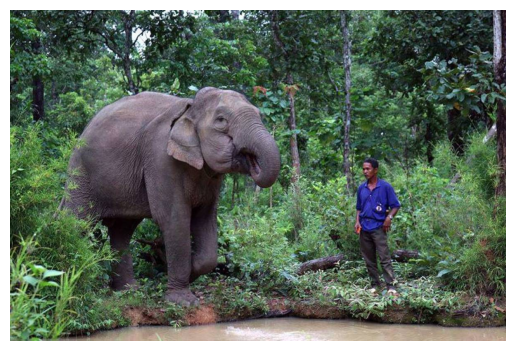

In [6]:
task_prompt2 = '<MORE_DETAILED_CAPTION>'
image = Image.open('testimages/animal1.jpg')
long_caption1 = list(florence2(task_prompt2, image).values())[0]

print('\n'.join(textwrap.wrap(long_caption1)))

plt.imshow(image);
plt.axis('off');

# Object Detection

In [7]:
task_prompt3 = '<OD>'
od_results = florence2(task_prompt3, image)  
od_results['<OD>']

{'bboxes': [[118.20000457763672,
   184.6304931640625,
   666.6000366210938,
   717.2954711914062],
  [826.2000122070312,
   360.04949951171875,
   955.800048828125,
   678.8474731445312]],
 'labels': ['elephant', 'person']}

In [8]:
def plot_bbox(image, data):
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

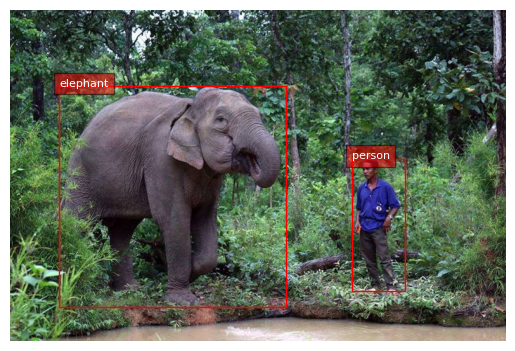

In [9]:
plot_bbox(image, od_results['<OD>']);

# Guided object detection

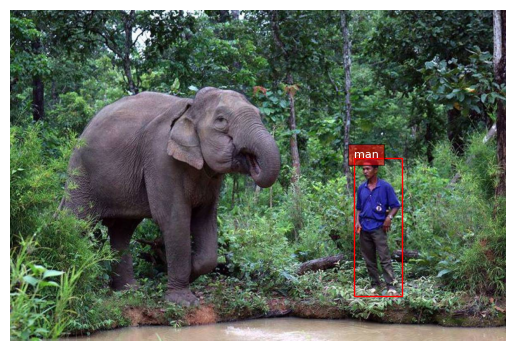

In [10]:
task_prompt4 = "<CAPTION_TO_PHRASE_GROUNDING>"

result = florence2(task_prompt4, image, text_input="man")

plot_bbox(image, result['<CAPTION_TO_PHRASE_GROUNDING>']);

# OCR

In [19]:
task_prompt = '<OCR>'
image = Image.open('testimages/Site-safety-rules.jpg')

results_ocr = florence2(task_prompt,image)

print(results_ocr)

{'<OCR>': '\nSITE SAFETY NOTICEUNAUTHORISED ENTRY TO THISSITE IS STRICTLY PROHIBITEDWARNING CONSTRUCTION IN PROGRESSPARENTS ARE ADVISED TO WARN CHILDRENOF THE DANGERS OF ENTERING CONSTruction SITES1. ALL VISITORS MUST REPORT TO THE SITE OFFICE.2. PERMISSION MUST BE OBTAINED BEFORE ENTERING THE SITE OR WORK AREA.3. SAFETy SIGNS & PROCEDURES MUST BE OBSERVED.4. PERSONAL PROTECTION & SAFETYE EQUIPMENT MUST BE USED AT ALL TIMES.5. ALL PERSONS ENTERING THIS SITE MUST COMPLY WITH THE REGULATIONS UNDERTHE HEALTH & SAFELY AT WORK ACT 2005.SAFETY HELMETS & PROTECTIVE FOOTWEARMUST BE WORN AT ALL TIMESSAFE PASS REQUIREDTO WORK ON THIS SITSITE RULES\n'}


# OCR with Region

In [16]:
task_prompt = '<OCR_WITH_REGION>'
image = Image.open('testimages/text.jpg')

results_ocr = florence2(task_prompt,image)

print(results_ocr)

{'<OCR_WITH_REGION>': {'quad_boxes': [[33.1775016784668, 33.1245002746582, 148.00050354003906, 33.1245002746582, 148.00050354003906, 69.0634994506836, 33.1775016784668, 69.0634994506836], [233.39651489257812, 27.928499221801758, 293.4045104980469, 27.928499221801758, 293.4045104980469, 53.90850067138672, 233.39651489257812, 53.90850067138672], [52.218502044677734, 72.09449768066406, 131.2675018310547, 72.09449768066406, 131.2675018310547, 101.97149658203125, 52.218502044677734, 101.97149658203125], [208.58551025390625, 61.269500732421875, 319.3695068359375, 61.269500732421875, 319.3695068359375, 87.24949645996094, 208.58551025390625, 87.24949645996094], [379.37750244140625, 37.02149963378906, 543.822509765625, 37.02149963378906, 543.822509765625, 72.09449768066406, 379.37750244140625, 72.09449768066406], [238.58950805664062, 92.44550323486328, 289.3655090332031, 88.1155014038086, 290.5195007324219, 108.03350067138672, 238.58950805664062, 111.06449890136719], [398.41851806640625, 83.352

In [14]:
def draw_ocr_bboxes(image, prediction):
    """
    Draw OCR BBox
    """
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']

    for box, label in zip(bboxes, labels):
        color = 'lime'
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=4, outline=color)
        draw.text((new_box[0] + 8, new_box[1] + 2),
                  "{}".format(label),
                  align="right",
                  fill=color)
    
    display(image)

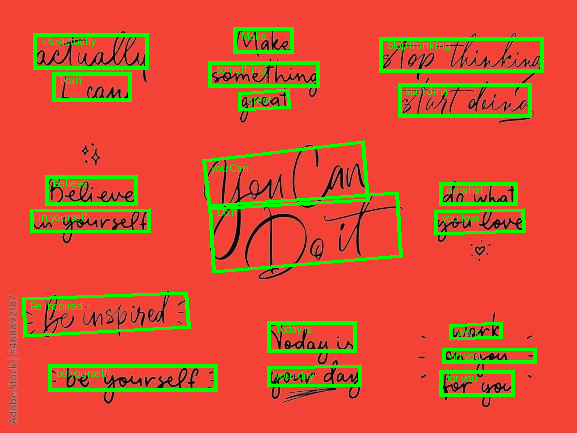

In [15]:
draw_ocr_bboxes(image, results_ocr['<OCR_WITH_REGION>'])

# Segmentation

In [22]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'

image = Image.open('testimages/animal1.jpg')
results_seg = florence2(task_prompt,image, text_input="a man")

print(results_seg)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[858.6000366210938, 364.05450439453125, 862.2000122070312, 360.8504943847656, 864.6000366210938, 360.04949951171875, 868.2000122070312, 359.2485046386719, 875.4000244140625, 359.2485046386719, 879.0000610351562, 360.04949951171875, 881.4000244140625, 360.8504943847656, 883.800048828125, 361.6514892578125, 886.2000122070312, 364.05450439453125, 889.800048828125, 367.2585144042969, 891.0000610351562, 368.8605041503906, 892.2000122070312, 372.06451416015625, 892.2000122070312, 382.4775085449219, 891.0000610351562, 383.27850341796875, 889.800048828125, 386.4825134277344, 889.800048828125, 391.28851318359375, 888.6000366210938, 392.0895080566406, 887.4000244140625, 395.2934875488281, 887.4000244140625, 401.7015075683594, 888.6000366210938, 404.9054870605469, 889.800048828125, 406.50750732421875, 892.2000122070312, 408.9104919433594, 894.6000366210938, 409.71148681640625, 897.0000610351562, 409.71148681640625, 899.4000244140625, 412.1145

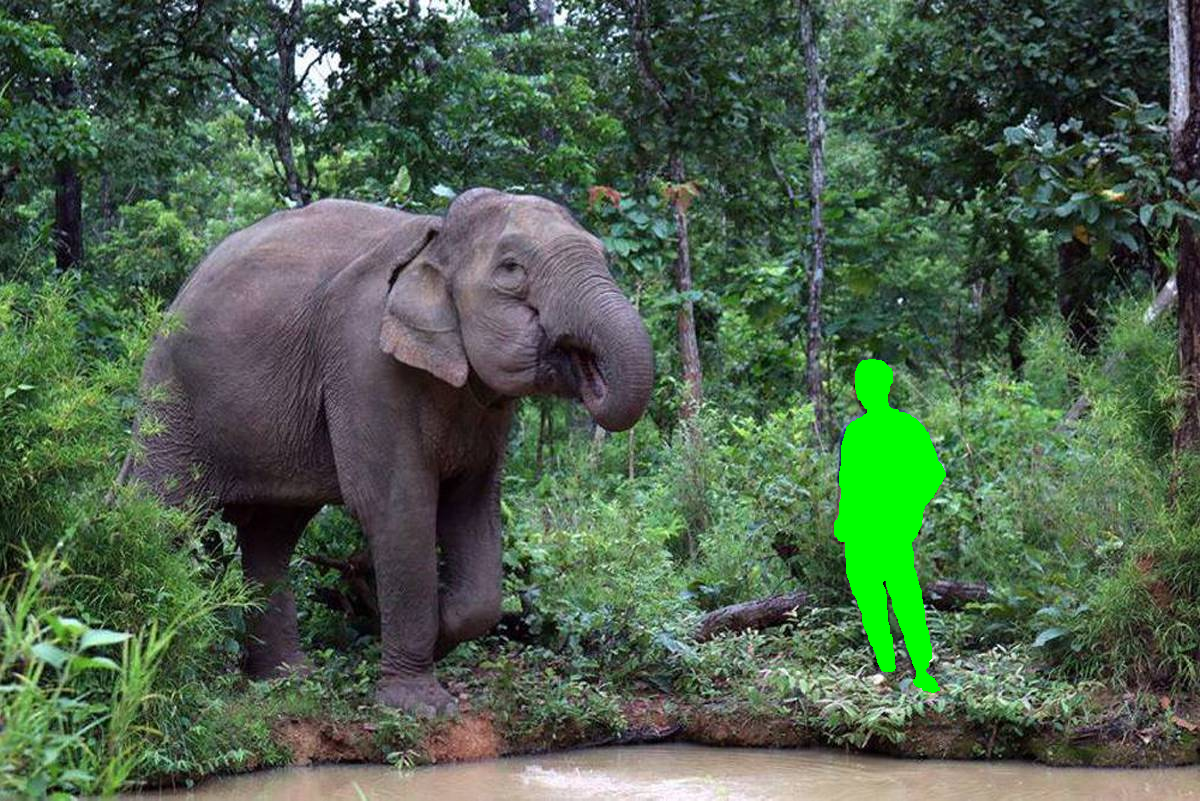

In [23]:
def draw_polygons(image, prediction, fill_mask=False):
    draw = ImageDraw.Draw(image)
    scale = 1

    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = "lime"
        fill_color = "lime" if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    display(image)


draw_polygons(image,
              results_seg['<REFERRING_EXPRESSION_SEGMENTATION>'],
              fill_mask=True)